In [11]:
#Module imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 
import os 

In [12]:
##Preprocessing##
#Read all input files into DataFrames 
formatted_dir = "formatted_input"
bpm_path = "{0}/19isolates_BPM.csv".format(formatted_dir)
mcseed_path = "{0}/19isolates_mcseed_pathwaycomplete.csv".format(formatted_dir)
# dc_tpm_path = "{0}/dc2ndadd_merged_tpm_data.tsv".format(formatted_dir) #Deprecated dataset 
# rob_tpm_path = "{0}/rob3rd_merged_tpm_data.tsv".format(formatted_dir)
# dc_count_path = "{0}/dc2ndadd_merged_count_data.tsv".format(formatted_dir)
# rob_count_path = "{0}/rob3rd_merged_count_data.tsv".format(formatted_dir)
#Flexible whitespace parsing - tpm first column is tab separated then space separated 
# rob_tpm_df = pd.read_csv(rob_tpm_path,sep=r"\s+")
# dc_tpm_df = pd.read_csv(dc_tpm_path,sep=r"\s+")
# rob_count_df = pd.read_csv(rob_count_path,sep=r"\s+")
# dc_count_df = pd.read_csv(dc_count_path,sep=r"\s+")
count_4th_trial_path = "{0}/4thtrial_merged_count_data.tsv".format(formatted_dir)
tpm_4th_trial_path = "{0}/4thtrial_merged_tpm_data.tsv".format(formatted_dir)
count_4t_df = pd.read_csv(count_4th_trial_path,sep=r"\s+")
tpm_4t_df = pd.read_csv(tpm_4th_trial_path,sep=r"\s+")

bpm_df = pd.read_csv(bpm_path)
#Process GO annotations from semicolon separated string into list of entries for columns Functional Pathway and Phenotype
mcseed_df = pd.read_csv(mcseed_path)
for col in ["Functional pathway", "Phenotype"]:
    mcseed_df.loc[:,col] = mcseed_df.loc[:,col].str.split(";")

#Set indices: BPM -> Isolate name; mcseed -> Locus tag; TPM -> target_id (locus)
bpm_df.set_index("Isolate name",inplace=True)
mcseed_df.set_index("Locus tag",inplace=True)
# rob_tpm_df.set_index("target_id",inplace=True)
# dc_tpm_df.set_index("target_id",inplace=True)
# rob_count_df.set_index("target_id",inplace=True)
# dc_count_df.set_index("target_id",inplace=True)
count_4t_df.set_index("target_id",inplace=True)
tpm_4t_df.set_index("target_id",inplace=True)

bpm_df = bpm_df.transpose().drop(index="# functions")
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
STRAIN_TAGS = dict(zip(bpm_df.columns,STRAIN_ABBREVS))
SHORT_ABBREVS = [abbrev[:3] for abbrev in STRAIN_ABBREVS]
STRAIN_ABBREV_TO_FULL = dict(zip(SHORT_ABBREVS, bpm_df.columns))

for strain in STRAIN_TAGS:
    strain_abbrev = STRAIN_TAGS[strain]
    if not (strain == "Blautia obeum Bg7063_SSTS2015" and strain_abbrev == "Rob"): 
        assert(strain[0] == strain_abbrev[0])

#BPM Summary statistics 
print("BPM=1 pathways by strain")
print(bpm_df.sum())
print("Total BPM=1 pathways: {0}".format(bpm_df.sum().sum()))

BPM=1 pathways by strain
Isolate name
Bifidobacterium breve Bgsng463_m5_93            46
Bifidobacterium catenulatum Bgsng468_m22_84     44
Bifidobacterium longum infantis 40721_2D9_SN    50
Blautia luti Bg7063                             53
Blautia obeum Bg7063_SSTS2015                   53
Dorea formicigenerans Bg7063                    43
Dorea longicatena Bg7063                        45
Enterococcus_avium_Bang_SAM2_39_S1              57
Escherichia coli PS_131_S11                     77
Faecalibacterium prausnitzii Bg7063             43
Lactococcus garvieae Bang155_08_4B6_JG2017      32
Ligilactobacillus ruminis ATCC_25644            33
Mitsuokella multacida DSM_20544                 45
Prevotella copri PS_131_S11                     49
Prevotella stercorea DSM_18206                  29
Ruminococcus gnavus M8243_3A11_TMS_2014         63
Ruminococcus torques Bg7063                     50
Streptococcus gallolyticus PS_064_S07           42
Streptococcus pasteriuanus Bang_SAM2_39_S1  

In [13]:
#Assertion testing and visual inspection of DFs 
#assert(len(mcseed_df)==len(mcseed_df.index.unique())) #False - locus tags can have multiple entries in mcseed_df, corresponding
#to different subcomponents of same locus; must handle duplicate locus entries in tpm_df 
# assert(len(rob_tpm_df)==len(rob_tpm_df.index.unique()))
# assert(len(dc_tpm_df)==len(dc_tpm_df.index.unique()))
#Concatenate DC and Rob tpm DFs
# tpm_df = pd.concat([dc_tpm_df,rob_tpm_df])
#Concatenate defined community and Rob counts data, convert counts to int 
# count_df = pd.concat([dc_count_df,rob_count_df])
#Sanity checks on concatenated tpm and counts
# assert(len(tpm_df) == (len(rob_tpm_df) + len(dc_tpm_df)))
# assert(len(count_df) == (len(rob_count_df) + len(dc_count_df)))


tpm_df = tpm_4t_df.copy()
count_df = count_4t_df.copy()
# display(tpm_df)
# display(count_df)
#Remove .tpm and .est_counts tags from column names in tpm and count dfs 
tpm_df.columns = tpm_df.columns.str.extract('(.*)\.tpm',expand=False)
count_df.columns = count_df.columns.str.extract('(.*)\.est_counts',expand=False)


assert((tpm_df.columns==count_df.columns).all())
#Filter down to only 1C (Pre-weaning P.copri) and 2A (No P. copri)
samples_1C, samples_2B = [tpm_df.columns.str.contains(tag) for tag in ["1C_Pup","2B_Pup"]] #Boolean arrays 
samples_1C, samples_2B = tpm_df.columns[samples_1C], tpm_df.columns[samples_2B]#Filtered column lists
reordered_cols = pd.Index(list(samples_1C)+list(samples_2B))
print(reordered_cols)
tpm_df, count_df = tpm_df.loc[:,reordered_cols], count_df.loc[:,reordered_cols]
#
count_df_int = count_df.copy()
count_df_int.iloc[:,:] = np.ceil(count_df_int.iloc[:,:]).astype(int)
#mcseed_df_duplicates = mcseed_df.index[mcseed_df.index.duplicated(keep=False)]

show_tables = True 
if show_tables:
    display(mcseed_df)
    display(tpm_df)
    display(bpm_df)
    
full_dir_path = "formatted_output/4th_trial/full"
if not os.path.exists(full_dir_path):
    os.makedirs(full_dir_path)
overwrite_files = True
if overwrite_files:
    tpm_df.to_csv("{0}/full_merged_tpm.csv".format(full_dir_path))
    count_df.to_csv("{0}/full_merged_count.csv".format(full_dir_path))
    count_df_int.to_csv("{0}/full_merged_count_int.csv".format(full_dir_path))

display(count_df)
display(count_df_int)

Index(['Pup_1-cecal_contents_53_1C_Pup_1', 'Pup_1-ileal_contents_53_1C_Pup_1',
       'Pup_2-cecal_contents_53_1C_Pup_2', 'Pup_2-ileal_contents_53_1C_Pup_2',
       'Pup_3-cecal_contents_53_1C_Pup_3', 'Pup_3-ileal_contents_53_1C_Pup_3',
       'Pup_4-cecal_contents_53_1C_Pup_4', 'Pup_4-ileal_contents_53_1C_Pup_4',
       'Pup_5-cecal_contents_53_1C_Pup_5', 'Pup_5-ileal_contents_53_1C_Pup_5',
       'Pup_6-cecal_contents_53_1C_Pup_6', 'Pup_6-ileal_contents_53_1C_Pup_6',
       'Pup_7-cecal_contents_53_1C_Pup_7', 'Pup_7-ileal_contents_53_1C_Pup_7',
       'Pup_8-cecal_contents_53_1C_Pup_8', 'Pup_8-ileal_contents_53_1C_Pup_8',
       'Pup_1-cecal_contents_54_2B_Pup_1', 'Pup_1-ileal_contents_54_2B_Pup_1',
       'Pup_2-cecal_contents_54_2B_Pup_2', 'Pup_2-ileal_contents_54_2B_Pup_2',
       'Pup_3-cecal_contents_54_2B_Pup_3', 'Pup_3-ileal_contents_54_2B_Pup_3',
       'Pup_4-cecal_contents_54_2B_Pup_4', 'Pup_4-ileal_contents_54_2B_Pup_4',
       'Pup_5-cecal_contents_54_2B_Pup_5', 'Pup_5-il

,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype
Locus tag,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,"[maltose utilization, maltooligosaccharides u...","[Mal, (Mal)n]"
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,"[maltose utilization, maltooligosaccharides u...","[Mal, (Mal)n]"
ANCJAENF_00014,Bifidobacterium breve Bgsng463_m5_93,MalG,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,"[maltose utilization, maltooligosaccharides u...","[Mal, (Mal)n]"
ANCJAENF_00052,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,"[galactose utilization, lactose utilization]","[Gal, Lac]"
ANCJAENF_00063,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,"[galactose utilization, lactose utilization]","[Gal, Lac]"
...,...,...,...,...,...,...
LDOIJNDB_02225,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_c,"PTS system, trehalose-specific IIC component (...",Carbohydrate utilization,[trehalose utilization],[Tre]
LDOIJNDB_02226,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_b,"PTS system, trehalose-specific IIB component (...",Carbohydrate utilization,[trehalose utilization],[Tre]
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,"[galactose utilization, lactose utilization]","[Gal, Lac]"


,Pup_1-cecal_contents_53_1C_Pup_1,Pup_1-ileal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_2-ileal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_3-ileal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_4-ileal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_5-ileal_contents_53_1C_Pup_5,...,Pup_3-cecal_contents_54_2B_Pup_3,Pup_3-ileal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_4-ileal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_5-ileal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_6-ileal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7,Pup_7-ileal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,,,,,,,
ANCJAENF_00001,678.600000,20.97070,167.432000,9.825210,715.706000,3.465060e+01,1534.45000,23.051100,1631.420000,50.70230,...,3.799670,1.530190,0.108305,0.067922,88.54310,630.0980,255.22700,0.244386,153.265000,0.881001
ANCJAENF_00002,6196.870000,124.49900,1705.060000,59.888400,9143.190000,1.574560e+02,13517.20000,126.393000,14086.200000,312.95700,...,36.250800,4.755110,0.971734,1.917570,742.91600,3082.2900,2084.49000,1.285410,1150.030000,4.975310
ANCJAENF_00003,678.600000,20.97070,167.432000,9.825210,715.706000,3.465060e+01,1534.45000,23.051100,1631.420000,50.70230,...,3.799670,1.530190,0.108305,0.067922,88.54310,630.0980,255.22700,0.244386,153.265000,0.881001
ANCJAENF_00004,6196.870000,124.49900,1705.060000,59.888400,9143.190000,1.574560e+02,13517.20000,126.393000,14086.200000,312.95700,...,36.250800,4.755110,0.971734,1.917570,742.91600,3082.2900,2084.49000,1.285410,1150.030000,4.975310
ANCJAENF_00005,6.251760,0.00000,0.554181,0.000000,3.599670,9.038230e-02,3.17250,0.000000,0.796541,0.00000,...,0.000000,0.000000,0.000000,0.000000,1.92123,0.0000,0.00000,0.000000,0.591864,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0.000000,6.27988,0.000000,0.000000,0.000000,5.026050e-09,0.00000,22.167900,0.000000,2.41611,...,0.000000,12.563000,0.000000,0.202981,0.00000,0.0000,0.00000,0.000000,0.000000,8.712830
LDOIJNDB_02260,1.411490,0.00000,5.109380,0.000000,4.975030,4.114010e-01,5.10357,0.842406,2.567400,0.00000,...,0.611705,0.000000,2.475080,0.654158,15.89970,0.0000,5.58507,10.036100,3.149660,0.000000
LDOIJNDB_02261,63.744900,59.79710,184.225000,173.775000,109.157000,4.862450e+01,114.33300,138.692000,135.114000,172.26000,...,50.878800,76.087600,88.956900,42.067600,94.70170,2508.0500,881.98300,65.596400,168.805000,218.904000


Isolate name,Bifidobacterium breve Bgsng463_m5_93,Bifidobacterium catenulatum Bgsng468_m22_84,Bifidobacterium longum infantis 40721_2D9_SN,Blautia luti Bg7063,Blautia obeum Bg7063_SSTS2015,Dorea formicigenerans Bg7063,Dorea longicatena Bg7063,Enterococcus_avium_Bang_SAM2_39_S1,Escherichia coli PS_131_S11,Faecalibacterium prausnitzii Bg7063,Lactococcus garvieae Bang155_08_4B6_JG2017,Ligilactobacillus ruminis ATCC_25644,Mitsuokella multacida DSM_20544,Prevotella copri PS_131_S11,Prevotella stercorea DSM_18206,Ruminococcus gnavus M8243_3A11_TMS_2014,Ruminococcus torques Bg7063,Streptococcus gallolyticus PS_064_S07,Streptococcus pasteriuanus Bang_SAM2_39_S1
Glc,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
Gal,0,0,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0,1
Fru,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
Man,0,0,0,0,0,0,0,1,1,0,1,1,1,0,0,0,0,1,1
Tag,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lys_d,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Met_d,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Pro_d,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Thr_d,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,0,0,0


,Pup_1-cecal_contents_53_1C_Pup_1,Pup_1-ileal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_2-ileal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_3-ileal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_4-ileal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_5-ileal_contents_53_1C_Pup_5,...,Pup_3-cecal_contents_54_2B_Pup_3,Pup_3-ileal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_4-ileal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_5-ileal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_6-ileal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7,Pup_7-ileal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,,,,,,,
ANCJAENF_00001,31592.600000,2852.4500,9574.71000,1148.4300,28120.200000,6.356800e+03,6.063660e+04,1768.360000,6.397330e+04,3300.96000,...,427.762000,202.3200,10.47990,14.633800,10404.10000,1370.69,20874.30000,51.33900,20041.30000,121.7910
ANCJAENF_00002,614048.000000,36221.9000,207898.00000,14958.8000,766224.000000,6.184710e+04,1.138520e+06,20773.500000,1.178570e+06,43596.60000,...,8698.240000,1344.3600,200.07000,884.377000,185254.00000,14274.50,363192.00000,577.35000,319494.00000,1471.7700
ANCJAENF_00003,31592.600000,2852.4500,9574.71000,1148.4300,28120.200000,6.356800e+03,6.063660e+04,1768.360000,6.397330e+04,3300.96000,...,427.762000,202.3200,10.47990,14.633800,10404.10000,1370.69,20874.30000,51.33900,20041.30000,121.7910
ANCJAENF_00004,614048.000000,36221.9000,207898.00000,14958.8000,766224.000000,6.184710e+04,1.138520e+06,20773.500000,1.178570e+06,43596.60000,...,8698.240000,1344.3600,200.07000,884.377000,185254.00000,14274.50,363192.00000,577.35000,319494.00000,1471.7700
ANCJAENF_00005,19.000000,0.0000,2.00000,0.0000,9.000000,1.000000e+00,8.000000e+00,0.000000,2.000000e+00,0.00000,...,0.000000,0.0000,0.00000,0.000000,15.00000,0.00,0.00000,0.00000,5.00000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0.000000,28.4212,0.00000,0.0000,0.000000,3.755120e-08,0.000000e+00,65.345600,0.000000e+00,6.05787,...,0.000000,54.3603,0.00000,1.266000,0.00000,0.00,0.00000,0.00000,0.00000,58.0740
LDOIJNDB_02260,0.285714,0.0000,1.28571,0.0000,0.857143,2.857140e-01,8.571430e-01,0.285714,4.285710e-01,0.00000,...,0.285714,0.0000,1.14286,0.571429,7.85714,0.00,2.14286,8.85714,1.71429,0.0000
LDOIJNDB_02261,5997.760000,16515.7000,21327.30000,41207.2000,8685.180000,1.813040e+04,9.143430e+03,21638.000000,1.073310e+04,22780.20000,...,11591.400000,20421.6000,17391.40000,18417.500000,22426.50000,11028.90,145913.00000,27970.50000,44534.00000,61472.0000


,Pup_1-cecal_contents_53_1C_Pup_1,Pup_1-ileal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_2-ileal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_3-ileal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_4-ileal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_5-ileal_contents_53_1C_Pup_5,...,Pup_3-cecal_contents_54_2B_Pup_3,Pup_3-ileal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_4-ileal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_5-ileal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_6-ileal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7,Pup_7-ileal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,,,,,,,
ANCJAENF_00001,31593.0,2853.0,9575.0,1149.0,28121.0,6357.0,60637.0,1769.0,63974.0,3301.0,...,428.0,203.0,11.0,15.0,10405.0,1371.0,20875.0,52.0,20042.0,122.0
ANCJAENF_00002,614048.0,36222.0,207898.0,14959.0,766224.0,61848.0,1138520.0,20774.0,1178570.0,43597.0,...,8699.0,1345.0,201.0,885.0,185254.0,14275.0,363192.0,578.0,319494.0,1472.0
ANCJAENF_00003,31593.0,2853.0,9575.0,1149.0,28121.0,6357.0,60637.0,1769.0,63974.0,3301.0,...,428.0,203.0,11.0,15.0,10405.0,1371.0,20875.0,52.0,20042.0,122.0
ANCJAENF_00004,614048.0,36222.0,207898.0,14959.0,766224.0,61848.0,1138520.0,20774.0,1178570.0,43597.0,...,8699.0,1345.0,201.0,885.0,185254.0,14275.0,363192.0,578.0,319494.0,1472.0
ANCJAENF_00005,19.0,0.0,2.0,0.0,9.0,1.0,8.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0.0,29.0,0.0,0.0,0.0,1.0,0.0,66.0,0.0,7.0,...,0.0,55.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,59.0
LDOIJNDB_02260,1.0,0.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,2.0,1.0,8.0,0.0,3.0,9.0,2.0,0.0
LDOIJNDB_02261,5998.0,16516.0,21328.0,41208.0,8686.0,18131.0,9144.0,21638.0,10734.0,22781.0,...,11592.0,20422.0,17392.0,18418.0,22427.0,11029.0,145913.0,27971.0,44534.0,61472.0


In [47]:
#Exploratory analysis - comparing mcSEED annotated genes to merged_counts 

def reads_distribution_QC(count_df, mcseed_df,cecal_filter=True,pco_col_pat='1C',no_pco_col_pat='2B'):
    bpm1_annotated_count_loci = count_df.loc[count_df.index.isin(mcseed_df.index)]
    if cecal_filter: 
        bpm1_annotated_count_loci = bpm1_annotated_count_loci.loc[:,bpm1_annotated_count_loci.columns.str.contains('cecal')]
        
    bpm_counts_total_entries = len(bpm1_annotated_count_loci)*len(bpm1_annotated_count_loci.columns)
    #BPM mapping and zeroes in all samples
    #1. Total BPM1 loci; 2. fraction of total input loci; 3. hard-coded retained BPM1 loci (based on downstream analysis)
    #4. Zero-expression in all samples 
    print("Total BPM1 mapped loci: {0}".format(len(bpm1_annotated_count_loci)))
    print("BPM1 loci as fraction of total counts: {:.2%}".format(len(bpm1_annotated_count_loci)/len(count_df)))
    print("Retained BPM1 loci: {:.2%}".format(1980/len(bpm1_annotated_count_loci)))
    print("Transcripts with 0 expression in all samples: {0}".format(len(bpm1_annotated_count_loci.loc[bpm1_annotated_count_loci.mean(axis=1)==0])))
    print("")
    #Pco vs no pco sample partitioning; zero-fraction of reads in all, then Pco, no pco partitions
    pco_bpm1_counts= bpm1_annotated_count_loci.loc[:,bpm1_annotated_count_loci.columns.str.contains(pco_col_pat)]
    no_pco_bpm1_counts= bpm1_annotated_count_loci.loc[:,bpm1_annotated_count_loci.columns.str.contains(no_pco_col_pat)]
    zero_fraction_alldata = sum(bpm1_annotated_count_loci.values.flatten()==0)/(len(bpm1_annotated_count_loci)*len(bpm1_annotated_count_loci.columns))
    pco_zero_fraction = sum(pco_bpm1_counts.values.flatten()==0)/(len(pco_bpm1_counts)*len(pco_bpm1_counts.columns))
    no_pco_zero_fraction = sum(no_pco_bpm1_counts.values.flatten()==0)/(len(no_pco_bpm1_counts)*len(no_pco_bpm1_counts.columns))
    print("0 expression as fraction of total dataset: {:.2%}".format(zero_fraction_alldata))
    print("0 expression as fraction of P.copri samples: {:.2%}".format(pco_zero_fraction))
    print("0 expression as fraction of No P.copri samples: {:.2%}".format(no_pco_zero_fraction))
    
    #feature means and log transformed histograms 
    PSEUDOCOUNT = 10**-3
    bpm1_feature_means = bpm1_annotated_count_loci.mean(axis=1)
    log2_feature_means = np.log2(bpm1_feature_means+PSEUDOCOUNT)
    log2_feature_means.replace([np.inf, -np.inf], np.nan, inplace=True)
    print ("===Transcript count means BPM 1 transcripts===")
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    sns.histplot(log2_feature_means,bins=30)
    ymin,ymax = ax.get_ylim()
    ax.vlines(4,ymin,ymax,color='black',linestyles='dashed')
    ax.set_ylim(ymin,ymax)
    ax.set_title("Log2 feature means")
    print("Fraction of Features with avg log2 expression > 4: {:.2%}".format(len(log2_feature_means[log2_feature_means>4])/len(log2_feature_means)))

    fig,ax = plt.subplots(1,1,figsize=(6,6))
    print ("===Transcript counts all data, BPM 1 transcripts===")
    log2_bpm1_counts  = np.log2(bpm1_annotated_count_loci+PSEUDOCOUNT)
    log2_bpm1_counts.replace([np.inf, -np.inf], np.nan, inplace=True)
#     assert(sum(log2_bpm1_counts.isna().values.flatten()))

    sns.histplot(log2_bpm1_counts.values.flatten(),bins=30,binrange=(-10,20))
    ymin,ymax = ax.get_ylim()
    ax.vlines(4,ymin,ymax,color='black',linestyles='dashed')
    ax.set_ylim(ymin,ymax)
    ax.set_title("Log2 counts distribution")
    
# reads_distribution_QC(count_df_int,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')
# reads_distribution_QC(count_df,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')


In [67]:
def log10_to_raw_abundance(abundance_df,abundance_scaling_factor=10**6,abundance_floor=0,drop_samples_re="1B"):
    STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Bli463","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
    abundance_converted  = abundance_df.copy()
    if STRAIN_ABBREVS[0] not in abundance_converted.columns:
        bact_columns = [col.strip() for col in abundance_converted.columns[3:-1].values]
        abbrevs_map = dict(zip(bact_columns,STRAIN_ABBREVS))
        abundance_converted.rename(columns=abbrevs_map,inplace=True)
    abundance_converted = abundance_converted.loc[:,STRAIN_ABBREVS]
    
    abundance_converted = abundance_converted.replace("ND",0)
    abundance_converted.loc[:,STRAIN_ABBREVS] = abundance_converted.loc[:,STRAIN_ABBREVS].astype(float)
    
    for col in STRAIN_ABBREVS:
        abundance_converted.loc[:,col] = np.power([10]*len(abundance_converted),
                                                        abundance_converted.loc[:,col].values)
        if abundance_floor: #For absolute abundance < 10^4, replace with 10^4 (prevent downstream overcorrection of transcript abundances)
            abundance_converted.loc[(abundance_converted.loc[:,col] < abundance_floor) & 
                                          (abundance_converted.loc[:,col] != 1),col] = abundance_floor
        abundance_converted.loc[:,col] = abundance_converted.loc[:,col].replace(1,0)
        #Replace 1 (from 10^0 abundance) with 0 
        abundance_converted.loc[:,col] = abundance_converted.loc[:,col]/(abundance_scaling_factor) #Scale by millions of genome equivalents
        
    #Drop 1B samples from abundance 
    if drop_samples_re and abundance_converted.columns.str.contains(drop_samples_re).any():
        sample_arm_re=r'[\w_]+[\w_]+_([12][ABC])_[\w+]'
        abundance_converted.loc[:,"Arm"] = abundance_converted.index.str.extract(sample_arm_re,expand=False)
        abundance_converted = abundance_converted.loc[~(abundance_converted["Arm"]=="1B"),:]
    return abundance_converted

In [71]:
cecal_abundance_path = "formatted_input/cecal_abundance.csv"
cecal_abundance_df = pd.read_csv(cecal_abundance_path,sep=",",index_col="MouseID")
cecal_abundance_df.columns = [col.strip() for col in cecal_abundance_df.columns]


# cecal_abundance_test = log10_to_raw_abundance(cecal_abundance_df,ABUNDANCE_SCALING_FACTOR,
#                                               abundance_floor=0,drop_samples_re="1B")

cecal_abundance_E6 = log10_to_raw_abundance(cecal_abundance_df,abundance_scaling_factor=10**6,
                                           abundance_floor=0,drop_samples_re="1B")
cecal_abundance_E7 = log10_to_raw_abundance(cecal_abundance_df,abundance_scaling_factor=10**7,
                                           abundance_floor=0,drop_samples_re="1B")
cecal_abundance_E6_floor =  log10_to_raw_abundance(cecal_abundance_df,abundance_scaling_factor=10**6,
                                           abundance_floor=10**4,drop_samples_re="1B")
cecal_abundance_E7_floor =  log10_to_raw_abundance(cecal_abundance_df,abundance_scaling_factor=10**7,
                                           abundance_floor=10**4,drop_samples_re="1B")


with pd.option_context('display.max_columns',None):
    display(cecal_abundance_E6)
    display(cecal_abundance_E6_floor)

cecal_abundance_dir = "{0}/cecal_abundance".format(full_dir_path)
if not os.path.exists(cecal_abundance_dir):
    os.makedirs(cecal_abundance_dir)
    
cecal_abundance_E7_floor.to_csv("{0}/cecal_abundance_E7_floored.csv".format(cecal_abundance_dir))
cecal_abundance_E6_floor.to_csv("{0}/cecal_abundance_E6_floored.csv".format(cecal_abundance_dir))
cecal_abundance_E7.to_csv("{0}/cecal_abundance_E7.csv".format(cecal_abundance_dir))
cecal_abundance_E6.to_csv("{0}/cecal_abundance_E6.csv".format(cecal_abundance_dir))

,Bbr,Bca,Bli2D9,Bli463,Blu,Rob,Dfo,Dlo,Eav,Eco,FprB,Lga4B6,Lru,Mmu,Pco,Pst,Rgn,Rto,Sga,Spa
MouseID,,,,,,,,,,,,,,,,,,,,
Pup_1-cecal_contents_53_1C_Pup_1,0.912011,1.778279,0.048978,0.0,0.000363,1.479108,0.000000,1.548817,0.691831,21.379621,0.000000,0.416869,0.050119,0.229087,19.498446,2.454709,3.235937,1.202264,0.338844,0.831764
Pup_2-cecal_contents_53_1C_Pup_2,0.213796,1.096478,0.015849,0.0,0.000224,0.741310,0.000034,2.398833,0.616595,11.748976,0.000035,0.194984,0.020417,0.141254,7.943282,1.288250,2.884032,0.380189,0.275423,0.676083
Pup_3-cecal_contents_53_1C_Pup_3,1.659587,7.762471,0.054954,0.0,0.000224,1.905461,0.000138,4.168694,1.023293,14.791084,0.000071,0.245471,0.478630,0.831764,24.547089,1.659587,3.311311,0.891251,0.380189,1.584893
Pup_4-cecal_contents_53_1C_Pup_4,1.905461,8.709636,0.066069,0.0,0.000427,2.290868,0.000000,3.630781,1.258925,20.417379,0.000000,0.407380,0.338844,1.047129,21.379621,3.162278,3.019952,0.741310,0.323594,1.445440
Pup_5-cecal_contents_53_1C_Pup_5,2.754229,12.589254,0.234423,0.0,0.003311,5.248075,0.000234,4.168694,1.548817,21.379621,0.000000,0.446684,0.501187,2.137962,21.877616,3.548134,3.235937,0.831764,0.021380,1.698244
Pup_6-cecal_contents_53_1C_Pup_6,4.570882,19.952623,0.125893,0.0,0.001585,2.398833,0.000204,8.317638,2.630268,28.840315,0.000000,0.812831,0.776247,1.905461,22.908677,3.388442,5.011872,0.870964,0.067608,4.073803
Pup_7-cecal_contents_53_1C_Pup_7,2.187762,9.120108,0.077625,0.0,0.002188,5.011872,0.000331,5.370318,1.737801,21.379621,0.000000,0.316228,0.112202,0.977237,45.708819,3.311311,8.511380,1.584893,0.186209,3.467369
Pup_8-cecal_contents_53_1C_Pup_8,1.621810,8.511380,0.407380,0.0,0.000724,2.818383,0.000372,7.079458,2.238721,38.904514,0.000000,0.501187,0.131826,1.148154,33.884416,0.000617,8.128305,3.890451,0.251189,7.079458
Pup_1-cecal_contents_53_1B_Pup_1,0.331131,2.884032,0.000000,0.0,0.000562,0.000832,0.000056,0.000912,1.380384,11.220185,0.000000,0.380189,0.109648,0.001995,9.332543,0.851138,3.019952,0.602560,0.389045,1.584893


,Bbr,Bca,Bli2D9,Bli463,Blu,Rob,Dfo,Dlo,Eav,Eco,FprB,Lga4B6,Lru,Mmu,Pco,Pst,Rgn,Rto,Sga,Spa
MouseID,,,,,,,,,,,,,,,,,,,,
Pup_1-cecal_contents_53_1C_Pup_1,0.912011,1.778279,0.048978,0.0,0.01,1.479108,0.00,1.548817,0.691831,21.379621,0.00,0.416869,0.050119,0.229087,19.498446,2.454709,3.235937,1.202264,0.338844,0.831764
Pup_2-cecal_contents_53_1C_Pup_2,0.213796,1.096478,0.015849,0.0,0.01,0.741310,0.01,2.398833,0.616595,11.748976,0.01,0.194984,0.020417,0.141254,7.943282,1.288250,2.884032,0.380189,0.275423,0.676083
Pup_3-cecal_contents_53_1C_Pup_3,1.659587,7.762471,0.054954,0.0,0.01,1.905461,0.01,4.168694,1.023293,14.791084,0.01,0.245471,0.478630,0.831764,24.547089,1.659587,3.311311,0.891251,0.380189,1.584893
Pup_4-cecal_contents_53_1C_Pup_4,1.905461,8.709636,0.066069,0.0,0.01,2.290868,0.00,3.630781,1.258925,20.417379,0.00,0.407380,0.338844,1.047129,21.379621,3.162278,3.019952,0.741310,0.323594,1.445440
Pup_5-cecal_contents_53_1C_Pup_5,2.754229,12.589254,0.234423,0.0,0.01,5.248075,0.01,4.168694,1.548817,21.379621,0.00,0.446684,0.501187,2.137962,21.877616,3.548134,3.235937,0.831764,0.021380,1.698244
Pup_6-cecal_contents_53_1C_Pup_6,4.570882,19.952623,0.125893,0.0,0.01,2.398833,0.01,8.317638,2.630268,28.840315,0.00,0.812831,0.776247,1.905461,22.908677,3.388442,5.011872,0.870964,0.067608,4.073803
Pup_7-cecal_contents_53_1C_Pup_7,2.187762,9.120108,0.077625,0.0,0.01,5.011872,0.01,5.370318,1.737801,21.379621,0.00,0.316228,0.112202,0.977237,45.708819,3.311311,8.511380,1.584893,0.186209,3.467369
Pup_8-cecal_contents_53_1C_Pup_8,1.621810,8.511380,0.407380,0.0,0.01,2.818383,0.01,7.079458,2.238721,38.904514,0.00,0.501187,0.131826,1.148154,33.884416,0.010000,8.128305,3.890451,0.251189,7.079458
Pup_1-cecal_contents_53_1B_Pup_1,0.331131,2.884032,0.000000,0.0,0.01,0.010000,0.01,0.010000,1.380384,11.220185,0.00,0.380189,0.109648,0.010000,9.332543,0.851138,3.019952,0.602560,0.389045,1.584893


In [74]:
#Ileal abundance
ileal_abundance_path = "formatted_input/ileal_abundance.csv"
ileal_abundance_df = pd.read_csv(ileal_abundance_path,sep=",",index_col="MouseID")
ileal_abundance_df.columns = [col.strip() for col in ileal_abundance_df.columns]


# ileal_abundance_test = log10_to_raw_abundance(ileal_abundance_df,ABUNDANCE_SCALING_FACTOR,
#                                               abundance_floor=0,drop_samples_re="1B")

ileal_abundance_E6 = log10_to_raw_abundance(ileal_abundance_df,abundance_scaling_factor=10**6,
                                           abundance_floor=0,drop_samples_re="1B")
ileal_abundance_E7 = log10_to_raw_abundance(ileal_abundance_df,abundance_scaling_factor=10**7,
                                           abundance_floor=0,drop_samples_re="1B")
ileal_abundance_E6_floor =  log10_to_raw_abundance(ileal_abundance_df,abundance_scaling_factor=10**6,
                                           abundance_floor=10**4,drop_samples_re="1B")
ileal_abundance_E7_floor =  log10_to_raw_abundance(ileal_abundance_df,abundance_scaling_factor=10**7,
                                           abundance_floor=10**4,drop_samples_re="1B")


with pd.option_context('display.max_columns',None):
    display(ileal_abundance_E7)
#     display(ileal_abundance_E7_floor)

ileal_abundance_dir = "{0}/ileal_abundance".format(full_dir_path)
if not os.path.exists(ileal_abundance_dir):
    os.makedirs(ileal_abundance_dir)
    
ileal_abundance_E7_floor.to_csv("{0}/ileal_abundance_E7_floored.csv".format(ileal_abundance_dir))
ileal_abundance_E6_floor.to_csv("{0}/ileal_abundance_E6_floored.csv".format(ileal_abundance_dir))
ileal_abundance_E7.to_csv("{0}/ileal_abundance_E7.csv".format(ileal_abundance_dir))
ileal_abundance_E6.to_csv("{0}/ileal_abundance_E6.csv".format(ileal_abundance_dir))

,Bbr,Bca,Bli2D9,Bli463,Blu,Rob,Dfo,Dlo,Eav,Eco,FprB,Lga4B6,Lru,Mmu,Pco,Pst,Rgn,Rto,Sga,Spa
MouseID,,,,,,,,,,,,,,,,,,,,
Pup_1-cecal_contents_53_1C_Pup_1,0.575440,0.933254,0.025119,0.0,0.000490,0.020417,0.000000,0.309030,0.154882,23.988329,0.0,0.138038,0.036308,0.003467,0.009120,0.000132,0.707946,0.165959,0.045709,0.512861
Pup_2-cecal_contents_53_1C_Pup_2,7.079458,17.782794,0.398107,0.0,0.003236,0.741310,0.000562,5.495409,6.606934,199.526231,0.0,2.089296,0.616595,0.007943,0.120226,0.013490,23.442288,2.754229,0.954993,13.803843
Pup_3-cecal_contents_53_1C_Pup_3,0.933254,1.698244,0.012589,0.0,0.000081,0.026303,0.000049,0.257040,0.093325,23.442288,0.0,0.032359,0.072444,0.002630,0.019498,0.002399,0.691831,0.134896,0.056234,0.331131
Pup_4-cecal_contents_53_1C_Pup_4,12.022644,26.302680,0.263027,0.0,0.003802,0.398107,0.000000,2.630268,2.570396,123.026877,0.0,0.851138,0.707946,0.007586,0.027542,0.002754,6.309573,1.174898,0.616595,6.025596
Pup_5-cecal_contents_53_1C_Pup_5,41.686938,54.954087,0.977237,0.0,0.003631,4.073803,0.001096,5.495409,3.467369,70.794578,0.0,1.698244,3.715352,0.177828,1.698244,0.154882,14.125375,2.884032,0.173780,12.589254
Pup_6-cecal_contents_53_1C_Pup_6,16.595869,33.113112,0.263027,0.0,0.006918,0.169824,0.000000,3.715352,2.041738,120.226443,0.0,1.174898,1.202264,0.019498,0.245471,0.025119,4.365158,0.912011,0.707946,6.456542
Pup_7-cecal_contents_53_1C_Pup_7,0.794328,1.548817,0.012023,0.0,0.000302,0.052481,0.000000,0.426580,0.288403,17.782794,0.0,1.047129,0.025704,0.003020,0.047863,0.003236,1.096478,0.245471,0.027542,0.588844
Pup_8-cecal_contents_53_1C_Pup_8,1.230269,3.890451,0.107152,0.0,0.000339,0.018621,0.000204,0.707946,0.316228,89.125094,0.0,0.398107,0.021380,0.007413,0.013183,0.002042,2.398833,0.707946,0.051286,1.584893
Pup_1-cecal_contents_53_1B_Pup_1,0.239883,1.000000,0.000000,0.0,0.000178,0.000224,0.000000,0.000062,0.229087,2.454709,0.0,0.104713,0.012303,0.014454,1.819701,0.000000,0.512861,0.346737,0.218776,0.338844


In [35]:
def vc_strain_locus_tag(expr_df,mcseed_df):
    """Returns a DataFrame indexed on locus tags for each strain, containing columns: 
        "Filtered Loci" - number of loci corresponding to that locus tag (ie loci per strain)
        "Strain" - full strain name corresponding to locus tag 
        :param pd.DataFrame expr_df: DataFrame indexed by ORFs containing (transformed) expression data, columns
        are samples 
        :param pd.DataFrame mcseed_df: DataFrame containing mcSEED annotations for loci, not necessarily for 
        all loci in expr_df 
    """
    vc_by_strain_locus_tag = expr_df.index.str.extract(r'(\w+)_\d+',expand=False).value_counts()
#     vc_by_strain_locus_tag.drop("ROSSTS7063_a2",inplace=True) #2nd3rd_trial specific error 
    locus_tag_strains = [mcseed_df.loc[mcseed_df.index.str.contains(lt),"Isolate name"].values[0] 
                             for lt in vc_by_strain_locus_tag.index] #if lt != "ROSSTS7063_a2"]
    locus_vc_df = pd.DataFrame(index=vc_by_strain_locus_tag.index,columns=["Filtered Loci","Strain"])
    locus_vc_df.loc[:,"Filtered Loci"] = vc_by_strain_locus_tag
    locus_vc_df.loc[:,"Strain"] = locus_tag_strains
    locus_vc_df.loc[:,"Abbreviation"] = [STRAIN_TAGS[lts] for lts in locus_tag_strains]
    return locus_vc_df

def abundance_correct_expr_df(expr_df,abundance_df,locus_vc_df,dtype='float'):
    abundance_corrected = expr_df.copy()
    abundance_corrected = abundance_corrected.loc[:,abundance_corrected.columns.isin(abundance_df.index)]
    abundance_corrected.loc[:,"Locus Tag"] = abundance_corrected.index.str.extract(r'(\w+)_\d+',expand=False)
    for lt in abundance_corrected["Locus Tag"].unique():
        strain_abbrev = locus_vc_df.loc[lt,"Abbreviation"]
        lt_expr_df = abundance_corrected.loc[abundance_corrected.loc[:,"Locus Tag"]==lt]
        abundance_data = abundance_df.loc[:,strain_abbrev]
        samples = list(abundance_data.index)
        lt_ac = lt_expr_df.loc[:,lt_expr_df.columns.isin(samples)]/abundance_data
        abundance_corrected.loc[lt_ac.index,samples] = lt_ac.loc[:,samples]
    abundance_corrected.drop(columns="Locus Tag",inplace=True)
#     display(abundance_corrected.loc[np.isinf(abundance_corrected).any(axis=1),:])
    abundance_corrected.replace([np.inf, -np.inf], np.nan, inplace=True)

    abundance_corrected.replace(np.nan,0,inplace=True)
    if dtype == 'float':
        abundance_corrected = abundance_corrected.astype('float')
    elif dtype == 'int':
        abundance_corrected_expr_int = np.floor(abundance_corrected_expr)
        abundance_corrected_expr_int = abundance_corrected_expr_int.astype('int')
    return abundance_corrected
    
locus_vc_df = vc_strain_locus_tag(count_df,mcseed_df)
# display(locus_vc_df)
abundance_corrected_expr = abundance_correct_expr_df(count_df,cecal_abundance_converted,locus_vc_df)
assert(len(count_df.loc[count_df.isna().any(axis=1)])==0)
assert(len(abundance_corrected_expr.loc[abundance_corrected_expr.isna().any(axis=1)])==0)
abundance_corrected_expr_int = np.floor(abundance_corrected_expr)
abundance_corrected_expr_int = abundance_corrected_expr_int.astype('int')
display(abundance_corrected_expr)
display(abundance_corrected_expr_int)

filt_tpm = tpm_df.loc[:,tpm_df.columns.isin(abundance_corrected_expr.columns)]
    
for abundance_data,tag in [(cecal_abundance_E6,"E6"),(cecal_abundance_E7,"E7")]:
    ac_expr_data = abundance_correct_expr_df(count_df,abundance_data,locus_vc_df) 
    ac_expr_int = np.floor(ac_expr_data).astype(int)
    filt_tpm = tpm_df.loc[:,tpm_df.columns.isin(ac_expr_data.columns)]
    
    if tag == "E6":
        ac_float_E6 = ac_expr_data
        ac_int_E6 = ac_expr_int
    elif tag == "E7":
        ac_float_E7 = ac_expr_data
        ac_int_E7 = ac_expr_int
    
    if ABUNDANCE_FLOOR:
        path_tag = tag + "_floor"
    else: 
        path_tag = tag
    full_dir_path = "formatted_output/4th_trial/full/".format(path_tag)
#     if not os.path.exists(full_dir_path):
#         os.makedirs(full_dir_path)
    AC_tag_dir = "{0}/{1}".format(full_dir_path,path_tag)
    if not os.path.exists(AC_tag_dir):
        os.makedirs(AC_tag_dir)
    if overwrite_files or not os.path.exists("{0}/abundance_corrected_count.csv".format(AC_tag_dir)):
        ac_expr_data.to_csv("{0}/abundance_corrected_count.csv".format(AC_tag_dir))
        ac_expr_int.to_csv("{0}/abundance_corrected_count_int.csv".format(AC_tag_dir))
        filt_tpm.to_csv("{0}/column_filtered_tpm.csv".format(AC_tag_dir))

,Pup_1-cecal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_6-cecal_contents_53_1C_Pup_6,Pup_7-cecal_contents_53_1C_Pup_7,Pup_8-cecal_contents_53_1C_Pup_8,Pup_1-cecal_contents_54_2B_Pup_1,Pup_2-cecal_contents_54_2B_Pup_2,Pup_3-cecal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,
ANCJAENF_00001,34640.597059,44784.283346,16944.096072,31822.540044,23227.301321,11461.289351,13799.858115,29359.602630,6.809423e+04,35585.230239,24615.133848,1047.990000,6269.090189,2.185808e+05,1.264521e+05
ANCJAENF_00002,673290.243385,972412.004033,461695.616280,597503.789644,427912.903010,261826.935631,225747.629263,550830.828748,1.034716e+06,485979.392501,500531.468054,20007.000000,111626.573559,3.803087e+06,2.015871e+06
ANCJAENF_00003,34640.597059,44784.283346,16944.096072,31822.540044,23227.301321,11461.289351,13799.858115,29359.602630,6.809423e+04,35585.230239,24615.133848,1047.990000,6269.090189,2.185808e+05,1.264521e+05
ANCJAENF_00004,673290.243385,972412.004033,461695.616280,597503.789644,427912.903010,261826.935631,225747.629263,550830.828748,1.034716e+06,485979.392501,500531.468054,20007.000000,111626.573559,3.803087e+06,2.015871e+06
ANCJAENF_00005,20.833086,9.354703,5.423036,4.198460,0.726156,0.875105,3.199617,0.616595,1.340051e+01,0.000000,0.000000,0.000000,9.038394,0.000000e+00,3.154787e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
LDOIJNDB_02260,0.343504,1.901704,0.540821,0.592998,0.252361,0.105202,0.164802,0.080716,2.036314e-01,1.559744,0.266644,1.472289,0.305678,3.097375e-01,3.581659e-01
LDOIJNDB_02261,7210.893535,31545.388327,5479.978109,6325.708054,6320.117837,2716.258151,3797.433120,3643.160334,5.017627e+03,9267.390730,10817.723902,22404.463253,872.492094,2.109085e+04,9.304471e+03


,Pup_1-cecal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_6-cecal_contents_53_1C_Pup_6,Pup_7-cecal_contents_53_1C_Pup_7,Pup_8-cecal_contents_53_1C_Pup_8,Pup_1-cecal_contents_54_2B_Pup_1,Pup_2-cecal_contents_54_2B_Pup_2,Pup_3-cecal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,
ANCJAENF_00001,34640,44784,16944,31822,23227,11461,13799,29359,68094,35585,24615,1047,6269,218580,126452
ANCJAENF_00002,673290,972412,461695,597503,427912,261826,225747,550830,1034715,485979,500531,20007,111626,3803087,2015870
ANCJAENF_00003,34640,44784,16944,31822,23227,11461,13799,29359,68094,35585,24615,1047,6269,218580,126452
ANCJAENF_00004,673290,972412,461695,597503,427912,261826,225747,550830,1034715,485979,500531,20007,111626,3803087,2015870
ANCJAENF_00005,20,9,5,4,0,0,3,0,13,0,0,0,9,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LDOIJNDB_02260,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
LDOIJNDB_02261,7210,31545,5479,6325,6320,2716,3797,3643,5017,9267,10817,22404,872,21090,9304


==E6 float==
Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 1032

0 expression as fraction of total dataset: 38.90%
0 expression as fraction of P.copri samples: 26.94%
0 expression as fraction of No P.copri samples: 52.57%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 3.46%
===Transcript counts all data, BPM 1 transcripts===
==E7 float==
Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 1032

0 expression as fraction of total dataset: 38.90%
0 expression as fraction of P.copri samples: 26.94%
0 expression as fraction of No P.copri samples: 52.57%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 21.40%
===Transcript counts all data, BPM 1 transcripts===


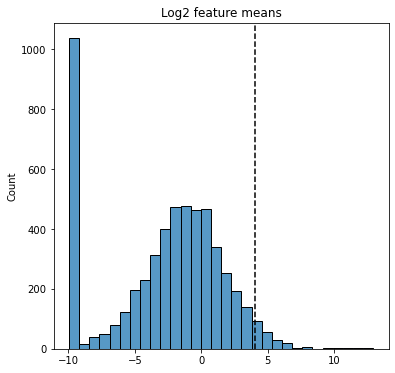

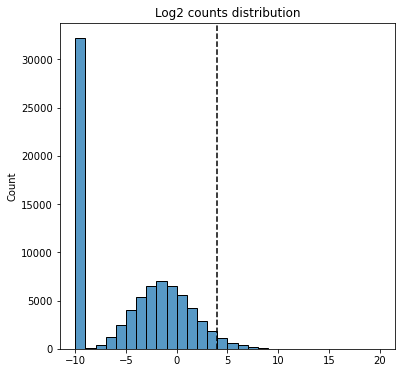

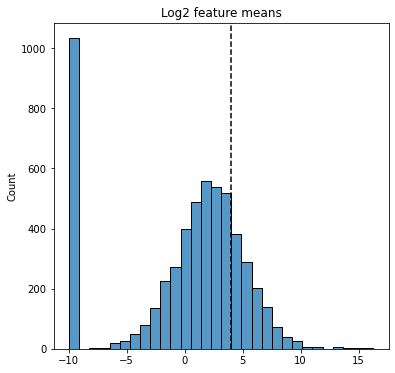

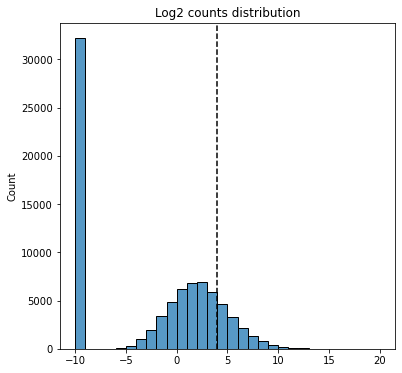

In [104]:
#Float AC counts
print("==E6 float==")
reads_distribution_QC(ac_float_E6,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')
print("==E7 float==")
reads_distribution_QC(ac_float_E7,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')

==E6 int==
Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 2744

0 expression as fraction of total dataset: 79.48%
0 expression as fraction of P.copri samples: 78.70%
0 expression as fraction of No P.copri samples: 80.37%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 3.37%
===Transcript counts all data, BPM 1 transcripts===
==E7 int==
Total BPM1 mapped loci: 5519
BPM1 loci as fraction of total counts: 11.41%
Retained BPM1 loci: 35.88%
Transcripts with 0 expression in all samples: 1324

0 expression as fraction of total dataset: 52.95%
0 expression as fraction of P.copri samples: 46.23%
0 expression as fraction of No P.copri samples: 60.63%
===Transcript count means BPM 1 transcripts===
Fraction of Features with avg log2 expression > 4: 21.02%
===Transcript counts all data, BPM 1 transcripts===


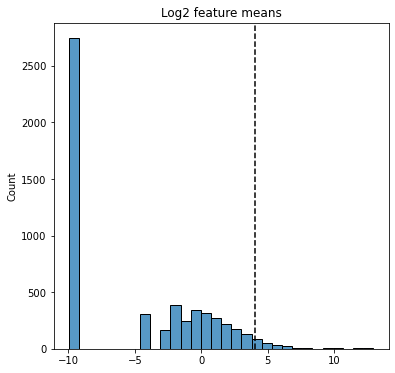

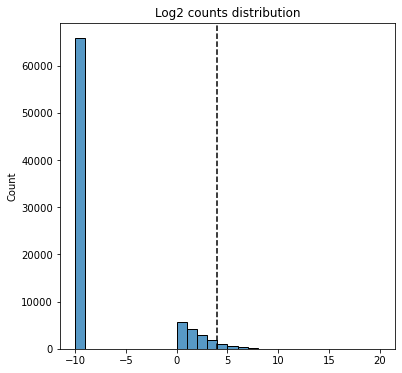

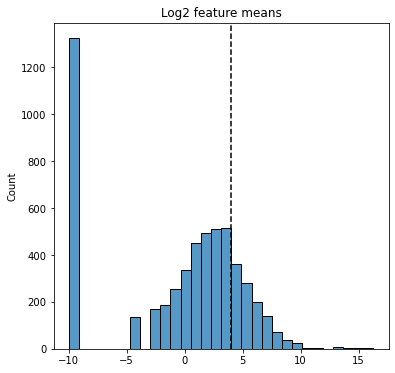

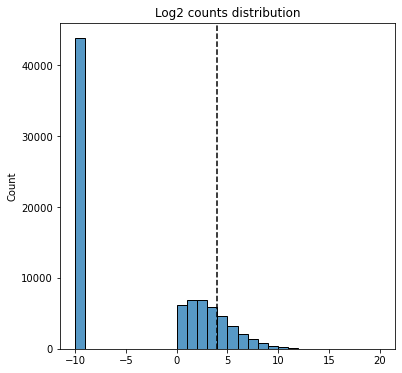

In [105]:
#Int AC counts
print("==E6 int==")
reads_distribution_QC(ac_int_E6,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')
print("==E7 int==")
reads_distribution_QC(ac_int_E7,mcseed_df,pco_col_pat='1C',no_pco_col_pat='2B')

In [40]:
display(cecal_abundance_E6)

,Treatment,Mouse Number,Sex,Bbr,Bca,Bli2D9,Bli463,Blu,Rob,Dfo,...,Lru,Mmu,Pco,Pst,Rgn,Rto,Sga,Spa,Total Bacterial Load,Arm
MouseID,,,,,,,,,,,,,,,,,,,,,
Pup_1-cecal_contents_53_1C_Pup_1,Arm 1 (Pre-weaning P. copri colonization),1,female,0.912011,1.778279,0.048978,0.0,0.000363,1.479108,0.000000,...,0.050119,0.229087,19.498446,2.454709,3.235937,1.202264,0.338844,0.831764,7.75,1C
Pup_2-cecal_contents_53_1C_Pup_2,Arm 1 (Pre-weaning P. copri colonization),2,male,0.213796,1.096478,0.015849,0.0,0.000224,0.741310,0.000034,...,0.020417,0.141254,7.943282,1.288250,2.884032,0.380189,0.275423,0.676083,7.48,1C
Pup_3-cecal_contents_53_1C_Pup_3,Arm 1 (Pre-weaning P. copri colonization),3,male,1.659587,7.762471,0.054954,0.0,0.000224,1.905461,0.000138,...,0.478630,0.831764,24.547089,1.659587,3.311311,0.891251,0.380189,1.584893,7.82,1C
Pup_4-cecal_contents_53_1C_Pup_4,Arm 1 (Pre-weaning P. copri colonization),4,male,1.905461,8.709636,0.066069,0.0,0.000427,2.290868,0.000000,...,0.338844,1.047129,21.379621,3.162278,3.019952,0.741310,0.323594,1.445440,7.85,1C
Pup_5-cecal_contents_53_1C_Pup_5,Arm 1 (Pre-weaning P. copri colonization),5,female,2.754229,12.589254,0.234423,0.0,0.003311,5.248075,0.000234,...,0.501187,2.137962,21.877616,3.548134,3.235937,0.831764,0.021380,1.698244,7.91,1C
Pup_6-cecal_contents_53_1C_Pup_6,Arm 1 (Pre-weaning P. copri colonization),6,male,4.570882,19.952623,0.125893,0.0,0.001585,2.398833,0.000204,...,0.776247,1.905461,22.908677,3.388442,5.011872,0.870964,0.067608,4.073803,8.03,1C
Pup_7-cecal_contents_53_1C_Pup_7,Arm 1 (Pre-weaning P. copri colonization),7,male,2.187762,9.120108,0.077625,0.0,0.002188,5.011872,0.000331,...,0.112202,0.977237,45.708819,3.311311,8.511380,1.584893,0.186209,3.467369,8.04,1C
Pup_8-cecal_contents_53_1C_Pup_8,Arm 1 (Pre-weaning P. copri colonization),8,female,1.621810,8.511380,0.407380,0.0,0.000724,2.818383,0.000372,...,0.131826,1.148154,33.884416,0.000617,8.128305,3.890451,0.251189,7.079458,8.07,1C
Pup_1-cecal_contents_54_2B_Pup_1,Arm 3 (No P. copri colonization),1,male,0.223872,1.584893,0.000000,0.0,0.002512,0.006761,0.000407,...,0.002042,0.001905,0.000000,0.000000,45.708819,5.370318,0.056234,9.120108,8.22,2B


In [41]:
edger_filtered_counts_fpath = "formatted_output/4th_trial/edgeR_filtered/edgeR_filtered_count.csv"
edger_filtered_counts = pd.read_csv(edger_filtered_counts_fpath,index_col=0)
edger_filtered_counts.index.name = "target_id"
edger_filtered_counts.columns = [col.replace(".","-") for col in edger_filtered_counts.columns]
# display(edger_filtered_counts)
edgeR_AC_expr = abundance_correct_expr_df(edger_filtered_counts,cecal_abundance_E6,locus_vc_df)

edgeR_AC_int = np.ceil(edgeR_AC_expr).astype(int)
# display(edgeR_AC_expr)
display(edgeR_AC_int)

edgeR_AC_int.to_csv("formatted_output/4th_trial/edgeR_filtered/edgeR_filt_AC.csv")

,Pup_1-cecal_contents_53_1C_Pup_1,Pup_2-cecal_contents_53_1C_Pup_2,Pup_3-cecal_contents_53_1C_Pup_3,Pup_4-cecal_contents_53_1C_Pup_4,Pup_5-cecal_contents_53_1C_Pup_5,Pup_6-cecal_contents_53_1C_Pup_6,Pup_7-cecal_contents_53_1C_Pup_7,Pup_8-cecal_contents_53_1C_Pup_8,Pup_1-cecal_contents_54_2B_Pup_1,Pup_2-cecal_contents_54_2B_Pup_2,Pup_3-cecal_contents_54_2B_Pup_3,Pup_4-cecal_contents_54_2B_Pup_4,Pup_5-cecal_contents_54_2B_Pup_5,Pup_6-cecal_contents_54_2B_Pup_6,Pup_7-cecal_contents_54_2B_Pup_7
target_id,,,,,,,,,,,,,,,
ANCJAENF_00001,34642,44786,16945,31823,23228,11462,13800,29360,68097,35663,24629,5642,6270,218589,126457
ANCJAENF_00002,673291,972413,461696,597504,427913,261827,225748,550831,1034716,486000,500576,103086,111627,3803088,2015871
ANCJAENF_00003,34642,44786,16945,31823,23228,11462,13800,29360,68097,35663,24629,5642,6270,218589,126457
ANCJAENF_00004,673291,972413,461696,597504,427913,261827,225748,550831,1034716,486000,500576,103086,111627,3803088,2015871
ANCJAENF_00006,87,136,44,19,21,8,25,14,99,0,231,0,66,42,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDOIJNDB_02252,50,27,33,7,5,1,10,18,21,10,30,78,13,7,20
LDOIJNDB_02253,79,98,58,7,15,1,31,37,62,55,69,164,22,23,58
LDOIJNDB_02254,8,11,6,3,1,0,3,2,5,8,6,25,2,4,5


In [43]:
def test_area():
    cecal_abundance_df = pd.read_csv(cecal_abundance_path,sep=",",index_col="MouseID")
    cecal_abundance_df.columns = [col.strip() for col in cecal_abundance_df.columns]
    cecal_abundance_df = cecal_abundance_df.rename(columns=abbrevs_map)
    cecal_abundance_converted  = cecal_abundance_df.copy()
    cecal_abundance_converted = cecal_abundance_converted.replace("ND",0)
    cecal_abundance_converted.loc[:,STRAIN_ABBREVS] = cecal_abundance_converted.loc[:,STRAIN_ABBREVS].astype(float)
    cecal_abundance_converted.index.name="test"
    
    for col in STRAIN_ABBREVS:
        cecal_abundance_converted.loc[:,col] = np.power([10]*len(cecal_abundance_converted),
                                                        cecal_abundance_converted.loc[:,col].values)
        cecal_abundance_converted.loc[(cecal_abundance_converted.loc[:,col] < 10**4) & 
                                      (cecal_abundance_converted.loc[:,col] != 1),col] = 10**4
        #Replace 1 (from 10^0 abundance) with 0 
        cecal_abundance_converted.loc[:,col] = cecal_abundance_converted.loc[:,col].replace(1,0) 
        cecal_abundance_converted.loc[:,col] = cecal_abundance_converted.loc[:,col]/(ABUNDANCE_SCALING_FACTOR)
#     display(cecal_abundance_converted)
    
# test_area()
# display(cecal_abundance_converted)

In [45]:
#ileal abundance
ileal_abundance_fpath = "formatted_input/ileal_abundance.csv"
ileal_abundance_df = pd.read_csv(ileal_abundance_fpath)
display(ileal_abundance_df)

,Treatment,MouseID,Mouse Number,Sex,B. breve Bgsng463.m5.93,B. catenulatum Bgsng463.m5.93,B. longum subsp. Infantis Bg2D9,B. longum subsp. Infantis Bg463,B. luti Bg7063,B. obeum Bg7063,...,L. garvieae Bang155.08_4B6_JG2017,L. ruminis ATCC 25644,M. multacida DSM 20544,P. copri PS131.S11,P. stercorea DSM 18206,R. gnavus M8243_3A11_TMS_2014,R. torques Bg7063,S. gallolyticus PS.064.S07,S. pasteriuanus Bang_SAM2.39.S1,Total bacterial load
0,Arm 1 (Pre-weaning P. copri colonization),Pup_1-cecal_contents_53_1C_Pup_1,1,female,6.76,6.97,5.40,0,3.69,5.31,...,6.14,5.56,4.54,4.96,3.12,6.85,6.22,5.66,6.71,8.44
1,Arm 1 (Pre-weaning P. copri colonization),Pup_2-cecal_contents_53_1C_Pup_2,2,male,7.85,8.25,6.60,0,4.51,6.87,...,7.32,6.79,4.90,6.08,5.13,8.37,7.44,6.98,8.14,9.45
2,Arm 1 (Pre-weaning P. copri colonization),Pup_3-cecal_contents_53_1C_Pup_3,3,male,6.97,7.23,5.10,0,2.91,5.42,...,5.51,5.86,4.42,5.29,4.38,6.84,6.13,5.75,6.52,8.45
3,Arm 1 (Pre-weaning P. copri colonization),Pup_4-cecal_contents_53_1C_Pup_4,4,male,8.08,8.42,6.42,0,4.58,6.60,...,6.93,6.85,4.88,5.44,4.44,7.80,7.07,6.79,7.78,9.26
4,Arm 1 (Pre-weaning P. copri colonization),Pup_5-cecal_contents_53_1C_Pup_5,5,female,8.62,8.74,6.99,0,4.56,7.61,...,7.23,7.57,6.25,7.23,6.19,8.15,7.46,6.24,8.10,9.34
5,Arm 1 (Pre-weaning P. copri colonization),Pup_6-cecal_contents_53_1C_Pup_6,6,male,8.22,8.52,6.42,0,4.84,6.23,...,7.07,7.08,5.29,6.39,5.40,7.64,6.96,6.85,7.81,9.28
6,Arm 1 (Pre-weaning P. copri colonization),Pup_7-cecal_contents_53_1C_Pup_7,7,male,6.90,7.19,5.08,0,3.48,5.72,...,7.02,5.41,4.48,5.68,4.51,7.04,6.39,5.44,6.77,8.38
7,Arm 1 (Pre-weaning P. copri colonization),Pup_8-cecal_contents_53_1C_Pup_8,8,female,7.09,7.59,6.03,0,3.53,5.27,...,6.60,5.33,4.87,5.12,4.31,7.38,6.85,5.71,7.20,9.00
8,Arm 2 (Post-weaning P. copri colonization),Pup_1-cecal_contents_53_1B_Pup_1,1,male,6.38,7.00,0.00,0,3.25,3.35,...,6.02,5.09,5.16,7.26,0.00,6.71,6.54,6.34,6.53,7.86
9,Arm 2 (Post-weaning P. copri colonization),Pup_2-cecal_contents_53_1B_Pup_2,3,male,5.66,6.33,0.00,0,3.42,3.53,...,6.76,5.08,3.40,4.39,0.00,6.19,5.49,6.90,6.35,8.26
